In [5]:
import numpy as np
import lapy
from lapy import TetMesh, Solver
import matplotlib.pyplot as plt
import numpy as np
import skimage.measure
import pygalmesh
import meshio
from scipy.ndimage import zoom
import os

os.mkdir(os.getcwd() + '/Files')

See https://github.com/meshpro/pygalmesh for examples and documentation on 3D mesh rendering.

# Rendering a 3D heart

#### Step 1: Rendering mesh

This one is based on a mathematical function.

In [3]:
class Heart(pygalmesh.DomainBase):
    def __init__(self):
        super().__init__()

    def eval(self, x):
        return (
            (x[0] ** 2 + 9.0 / 4.0 * x[1] ** 2 + x[2] ** 2 - 1) ** 3
            - x[0] ** 2 * x[2] ** 3
            - 9.0 / 80.0 * x[1] ** 2 * x[2] ** 3
        )

    def get_bounding_sphere_squared_radius(self):
        return 10.0

In [13]:
function = Heart()
mesh = pygalmesh.generate_mesh(function, max_cell_circumradius=0.0435)

In [14]:
mesh.write("Files/heart.vtk")

#### Step 2: Loading mesh and generating tetrahedra

In [15]:
mesh = meshio.read('Files/heart.vtk')

vertices = mesh.points
tetrahedra = mesh.cells_dict['tetra']

tet_mesh = TetMesh(vertices, tetrahedra)
print(vertices.shape)

(30993, 3)


#### Step 3: Solving eigenmodes

Solving 100 eigenmodes.

In [16]:
solver = Solver(tet_mesh)
eigenvalues, eigenvectors = solver.eigs(k=100)

# Squeezing vertex coordinates in arbitrary [0, 1] interval (major axis length of volume = 1)
vertices -= np.min(vertices) 
vertices /= np.max(vertices)

TetMesh with regular Laplace
Solver: spsolve (LU decomposition) ...


Visualizing eigenmodes.

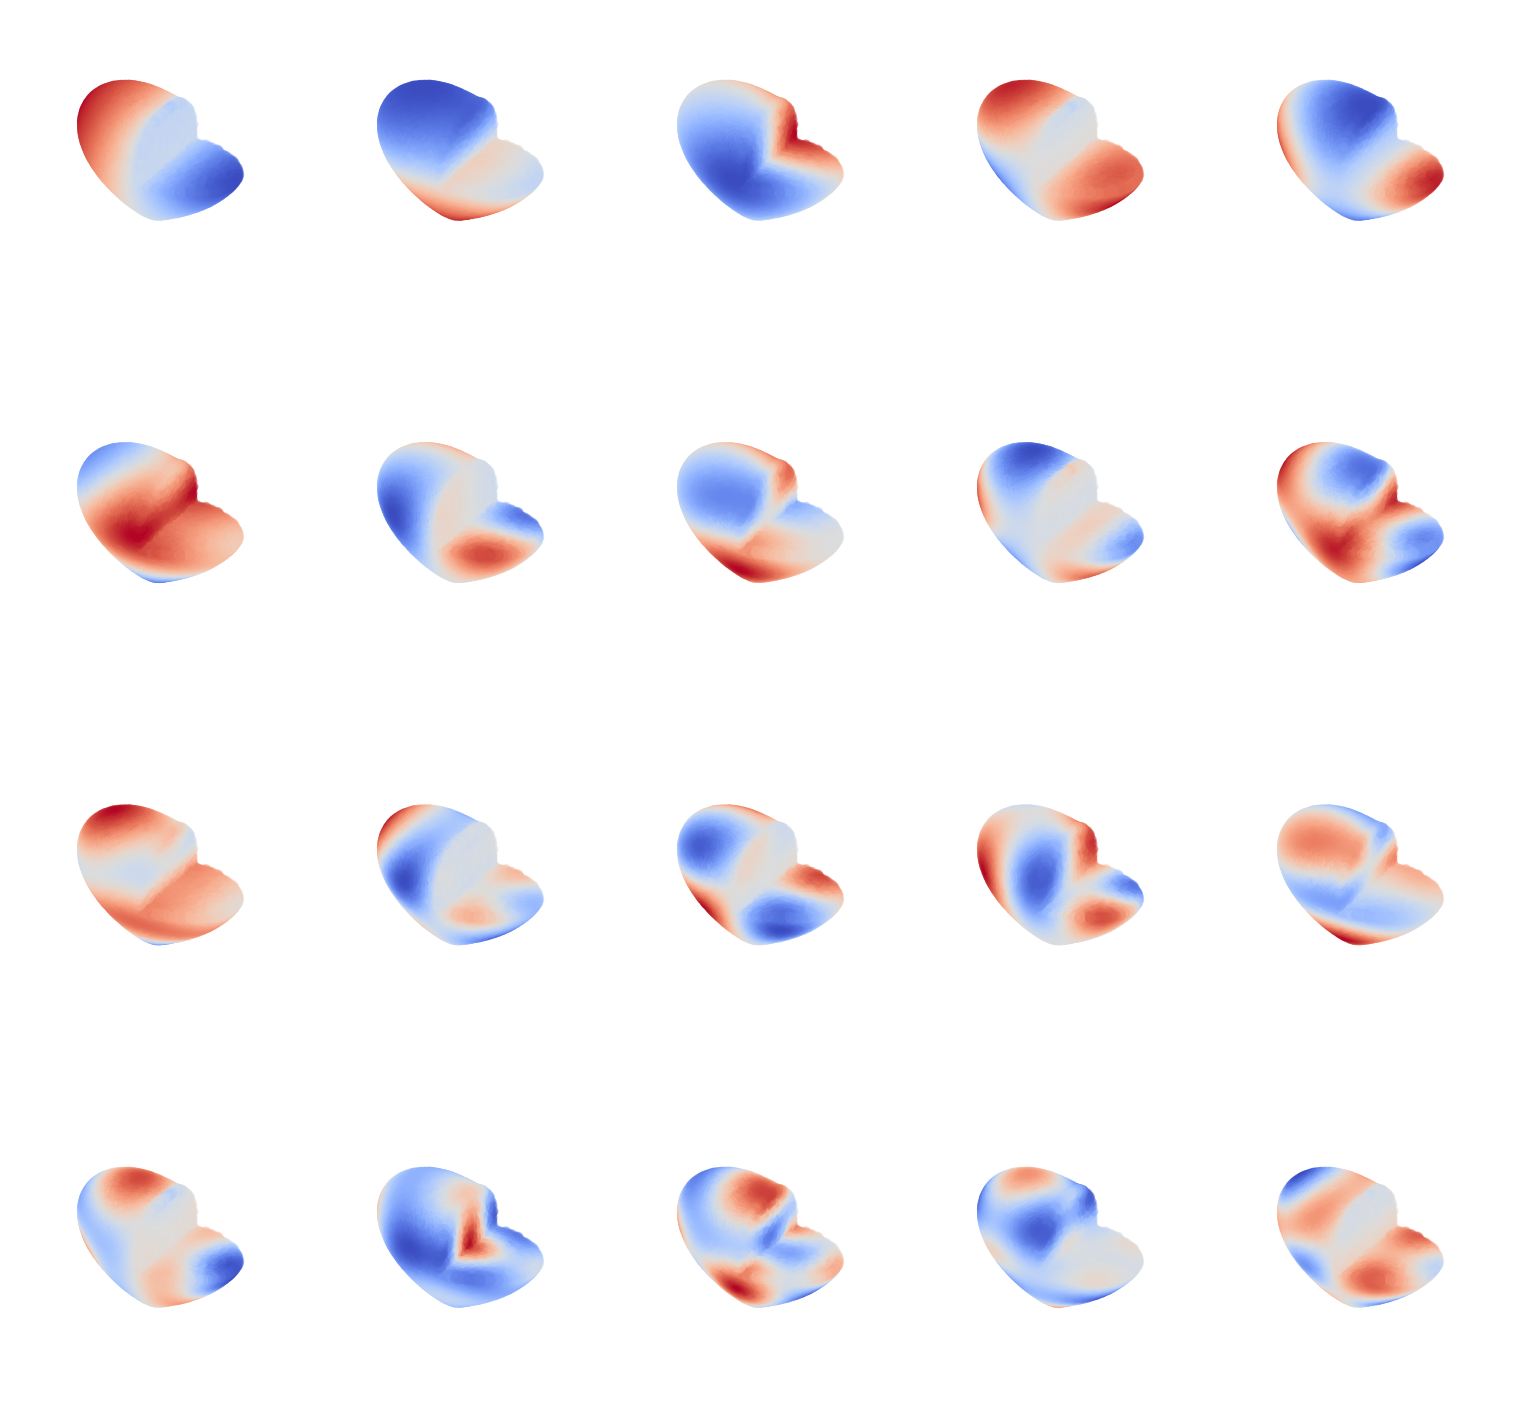

In [17]:
cut_volume = True
if cut_volume:
    cut = (vertices[:, 0] < 0.5) | (vertices[:, 2] < 0.5)
else:
    cut = vertices[:, 0] > -1   # Always true

fig, axes = plt.subplots(4, 5, subplot_kw={"projection": "3d"}, figsize=(10, 10), dpi=150)

for i in range(20):
    ax = axes.flatten()[i]
    ax.scatter(vertices[cut, 0], vertices[cut, 1], vertices[cut, 2], c=eigenvectors[cut, i+1], alpha=0.5, cmap='coolwarm')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_axis_off()

plt.tight_layout(pad=0)
#plt.savefig('Figures/eigenhearts.png')
plt.show()

Saving eigenmodes.

In [9]:
np.save('Files/vertices_heart.npy', vertices)
np.save('Files/eigenmodes_heart.npy', eigenvectors)

# Rendering a 3D ellipse

#### Step 1: Rendering mesh

Rendering a binary sphere in a (100, 100, 100)-sized array, then downscaling axes by different factors to get an ellipse.

In [34]:
L = 100
r = 0.75

x_ = np.linspace(-1.0, 1.0, L)
y_ = np.linspace(-1.0, 1.0, L)
z_ = np.linspace(-1.0, 1.0, L)
x, y, z = np.meshgrid(x_, y_, z_)

vol = np.empty((L, L, L), dtype=np.uint8)
idx = x ** 2 + y ** 2 + z ** 2 < r ** 2
vol[idx] = 1
vol[~idx] = 0

In [35]:
vol = zoom(vol, (1/2, 1/2, 2/2), order=1) # Downsampling by different factors in each axis

Generating mesh.

In [36]:
voxel_size = (0.1, 0.1, 0.1)

mesh = pygalmesh.generate_from_array(
    vol, voxel_size, max_facet_distance=0.25, max_cell_circumradius=0.125
)

mesh.write("Files/ellipse.vtk")

#### Step 2: Loading mesh and generating tetrahedra

In [37]:
mesh = meshio.read('Files/ellipse.vtk')

vertices = mesh.points
tetrahedra = mesh.cells_dict['tetra']

tet_mesh = TetMesh(vertices, tetrahedra)
print(vertices.shape)

(20623, 3)


#### Step 3: Solving eigenmodes

In [38]:
solver = Solver(tet_mesh)
eigenvalues, eigenvectors = solver.eigs(k=101)

# Squeezing vertex coordinates in arbitrary [0, 1] interval (major axis length of volume = 1)
vertices -= np.min(vertices) 
vertices /= np.max(vertices)

TetMesh with regular Laplace
Solver: spsolve (LU decomposition) ...


Displaying eigenmodes.

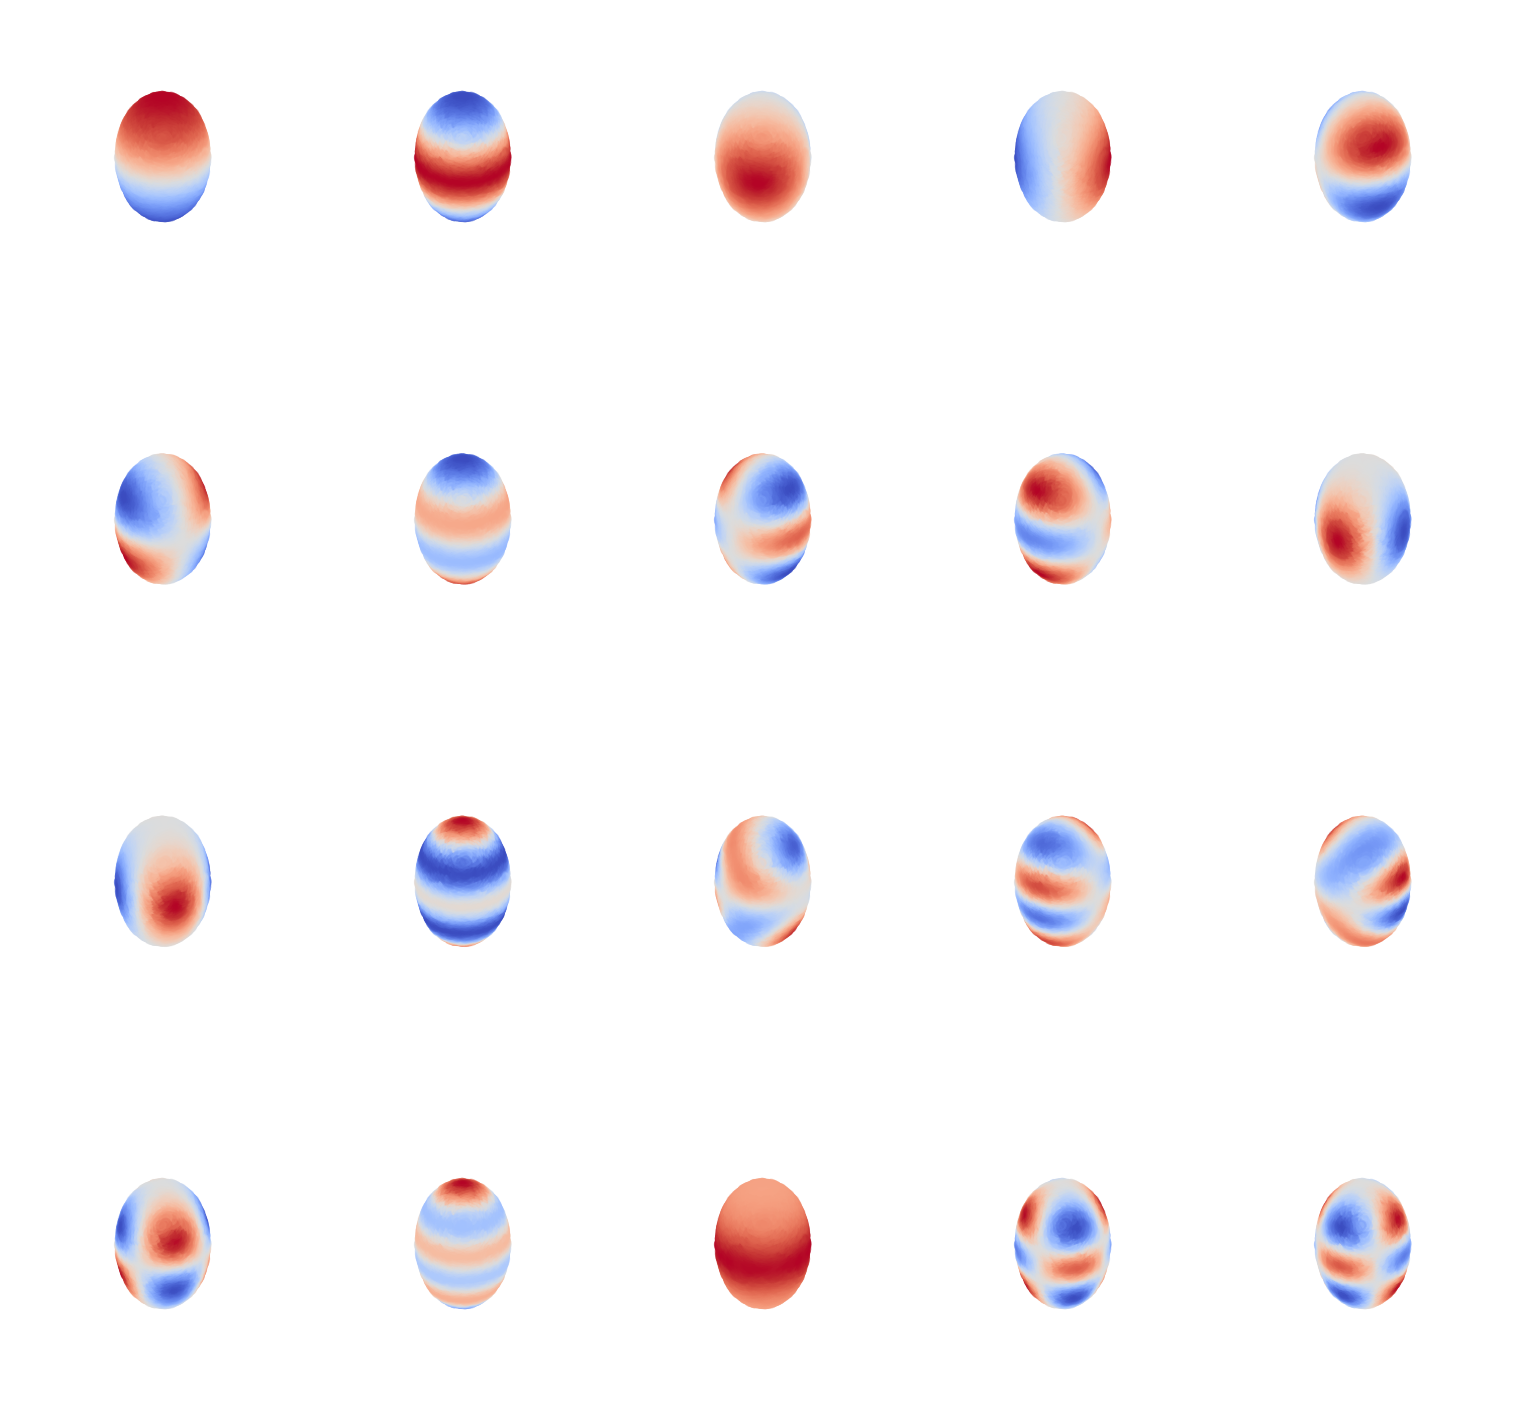

In [52]:
cut_volume = False
if cut_volume:
    cut = (vertices[:, 0] < 0.25) | (vertices[:, 2] < 0.5)
else:
    cut = vertices[:, 0] > -1   # Always true

fig, axes = plt.subplots(4, 5, subplot_kw={"projection": "3d"}, figsize=(10, 10), dpi=150)

for i in range(20):
    ax = axes.flatten()[i]
    ax.scatter(vertices[cut, 0] + 0.25, vertices[cut, 1] + 0.25, vertices[cut, 2], c=eigenvectors[cut, i + 1], alpha=0.5, cmap='coolwarm')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_axis_off()
    # ax.set_frame_on(False) # Older version of Matplotlib

plt.tight_layout(pad=0)
#plt.savefig('eigenhearts.png')
plt.show()

In [51]:
np.save('Files/vertices_ellipse.npy', vertices)
np.save('Files/eigenmodes_ellipse.npy', eigenvectors)